In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import copy
sns.set_context("paper")
sns.set(style="whitegrid")

In [2]:
def makeDataFrameFromFile(filename, percentage):
    with open(filename) as openfileobject:
        acc_before_pruning = []
        acc_after_pruning = []
        batches = []
        filters_per_layer = []
        full_accuracy_list = []
        tagged = False
        for line in openfileobject:
            #if "hard pruned" in line:
            #    number = int(line.split("hard pruned ")[1].split(" filters")[0])
            #    print(number)
            if "Accuracy" in line or "accuracy" in line:
                if "Couldn't reach original accuracy" in line: 
                    continue
                number = float(line.split("%")[0].split(" ")[-1])
                full_accuracy_list.append(number)
            if "INFO:lightnet.FLIR.prune:Filters before pruning:" in line or\
            "INFO:lightnet.FLIR.prune:Filters after pruning:" in line:
                tagged = True
                continue
            if tagged == True:
            #if "INFO:lightnet.FLIR.prune:[" in line and "Pruned" not in line:
                layer = []
                string = line.split("INFO:lightnet.FLIR.prune:[")[1].split("]")[0]
                layer = string.split(", ")
                count = 0
                for filter in layer:
                    layer[count] = float(filter)
                    count += 1 
                filters_per_layer.append(layer)
                tagged = False
            if "Trained for" in line:
                number = float(line.split("Trained for ")[1].split(" batches")[0])
                batches.append(number)
            if "Original accuracy" in line:
                number = float(line.split("INFO:lightnet.FLIR.prune:Original accuracy is ")[1].split("%")[0])
                acc_before_pruning.append(number)
            elif "Accuracy after retraining" in line:
                number = float(line.split("Accuracy after retraining: ")[1].split("%")[0])
                acc_before_pruning.append(number)
            elif "Accuracy after pruning" in line:
                number = float(line.split("Accuracy after pruning: ")[1].split("%")[0])
                acc_after_pruning.append(number)

        # No duplicates
        def Remove(duplicate): 
            final_list = [] 
            for num in duplicate: 
                if num not in final_list: 
                    final_list.append(num) 
            return final_list 
        
        filters_per_layer = Remove(filters_per_layer)
        
        percentage_pruned = []
        for number in range(len(acc_before_pruning)+1):
            percentage_pruned.append(round(100*(1-(1 - (percentage / 100))**(number+1)),2))
            #percentage_pruned.append(int(100*(1-(1 - (percentage / 100))**(number+1))))
        print(percentage_pruned)
        
        real_percentage_pruned = []
        count = -1
        totalnumber = 0
        for iteration in filters_per_layer:
            count += 1
            if count == 0:
                for filter in iteration:
                    totalnumber += filter
                continue
            number = 0
            for filter in iteration:
                    number += filter
            real_percentage_pruned.append(round(100 * (1-number/totalnumber),2))
        print(real_percentage_pruned)
            
        data = []
        for iteration in range(len(acc_after_pruning)):
            i = []
            i.append(acc_before_pruning[iteration])
            i.append(acc_after_pruning[iteration])
            i.append(acc_before_pruning[iteration] - acc_after_pruning[iteration])
            i.append(percentage_pruned[iteration])
            i.append(batches[iteration])
            if batches[iteration] == 10000:
                i.append(False)
            else:
                i.append(True)
            i.append(str(percentage))
            data.append(i)
        i = [acc_before_pruning[len(acc_before_pruning)-1], None, None, percentage_pruned[len(acc_before_pruning)-1]]
        data.append(i)

        accuracy = pd.DataFrame(data, columns = ['Before pruning', 'After pruning', 'Accuracy loss',\
                                                 'Percentage pruned', 'Batches trained' , 'Top limit', 'Percentage'])
        return accuracy, filters_per_layer, full_accuracy_list

In [3]:
def printAccuracy(accuracy):
    # Accuracy before vs after pruning
    plt.subplots(figsize=(14, 8))
    #plt.ylim(0, 100)
    plot = sns.barplot(x='Percentage pruned' ,y='Before pruning', data=accuracy, color='#557000')
    plot = sns.barplot(x='Percentage pruned' ,y='After pruning', data=accuracy, color='#639c0e')
    plot.set(xlabel = 'Percentage pruned [%]', ylabel = 'Accuracy [%]')
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
    return plot

In [4]:
def printAccuracyLoss(accuracy):
    # Accuracy drop from pruning
    plt.subplots(figsize=(14, 8))
    #plt.ylim(0, 100)
    plot = sns.barplot(x='Percentage pruned' ,y='Accuracy loss', data=accuracy, color='#9c150e')
    plot.set(xlabel = 'Percentage pruned [%]', ylabel = 'Accuracy loss [%]')
    return plot

In [5]:
def printFiltersPerLayer(filters):
    # FiltersPerLayer before and after being pruned
  
    index = []
    for i in range(len(filters[0])):
        index.append([filters[0][i], filters[1][i]])
    
    amount = pd.DataFrame(index, columns = ['Unpruned', 'Pruned'])
    
    plt.subplots(figsize=(14, 8))
    plot = sns.barplot(x=amount.index, y='Unpruned', data=amount, color='#557000')
    plot = sns.barplot(x=amount.index, y='Pruned', data=amount, color='#639c0e')
    plot.set(xlabel = 'Convolution layer', ylabel = 'Amount of filters')
    return plot

In [6]:
def printFiltersPerLayerPercentage(filters):
    # FiltersPerLayer before and after being pruned
  
    index = []
    for i in range(len(filters[0])):
        percentage = 100*(filters[0][i]-filters[1][i])/filters[0][i]
        index.append(percentage)
    
    amount = pd.DataFrame(index, columns = ['Percentage pruned'])
    
    plt.subplots(figsize=(14, 8))
    plt.ylim(0, 100)
    plot = sns.barplot(x=amount.index, y='Percentage pruned', data=amount, color='#9c150e')
    plot.set(xlabel = 'Convolution layer', ylabel = 'Amount of filters pruned [%]')
    return plot

In [7]:
def getFiltersOfLayers(filters_per_layer, layer1, layer2):
    filters = []
    filters.append(filters_per_layer[layer1])
    filters.append(filters_per_layer[layer2])
    return filters

In [8]:
def printFullAccuracyGraph(full_accuracy_list):
    df = pd.DataFrame(full_accuracy_list, columns = ['Accuracy'])
    
    plt.subplots(figsize=(14, 8))
    #plt.ylim(0, 100)
    plot = sns.lineplot(x=df.index, y='Accuracy', data=df, color='#9c150e')
    plot.set(xlabel = 'Epoch', ylabel = 'Accuracy [%]')
    return plot

In [9]:
def makeHeatMap(filters_per_layer, percentage):  
    filters_per_layer = copy.deepcopy(filters_per_layer)
    fullLayer = copy.deepcopy(filters_per_layer[0])
    for iteration in filters_per_layer:
        count = 0
        for layer in iteration:
            iteration[count] = 100 - (100 * iteration[count] / fullLayer[count])
            count += 1 
        
    df = pd.DataFrame({str(percentage.iloc[0]): filters_per_layer[1]},
                    index=['Conv. Layer 0','Conv. Layer 1','Conv. Layer 2','Conv. Layer 3', 'Conv. Layer 4','Conv. Layer 5',\
                           'Conv. Layer 6','Conv. Layer 7','Conv. Layer 8','Conv. Layer 9','Conv. Layer 10',\
                           'Conv. Layer 11','Conv. Layer 12','Conv. Layer 13','Conv. Layer 14','Conv. Layer 15',\
                           'Conv. Layer 16','Conv. Layer 17','Conv. Layer 18','Conv. Layer 19','Conv. Layer 20',\
                           'Conv. Layer 21','Conv. Layer 22'])
    
    for i in range(len(filters_per_layer)-1):
        if i == 0:
            continue
        df[str(percentage.iloc[i])] = filters_per_layer[i+1]

    plt.subplots(figsize=(14, 8))
    plot = sns.heatmap(df)
    plot.invert_yaxis()
    plot.set(xlabel = 'Percentage pruned')
    return plot

[12.5, 23.44, 33.01, 41.38, 48.71, 55.12, 60.73, 65.64, 69.93, 73.69, 76.98, 79.86, 82.38, 84.58, 86.51, 88.19]
[12.49, 23.42, 32.99, 41.37, 48.69, 55.09, 60.7, 65.61, 69.9, 73.66, 76.95, 79.83, 82.35, 84.55]
[10.0, 19.0, 27.1, 34.39, 40.95, 46.86, 52.17, 56.95, 61.26, 65.13, 68.62, 71.76, 74.58, 77.12, 79.41, 81.47, 83.32, 84.99]
[9.99, 18.99, 27.09, 34.37, 40.93, 46.84, 52.15, 56.94, 61.24, 65.11, 68.59, 71.72, 74.55, 77.09, 79.37, 81.43]
[7.5, 14.44, 20.85, 26.79, 32.28, 37.36, 42.06, 46.4, 50.42, 54.14, 57.58, 60.76, 63.71, 66.43, 68.95, 71.27, 73.43, 75.42]
[7.5, 14.43, 20.85, 26.78, 32.27, 37.34, 42.04, 46.38, 50.4, 54.11, 57.54, 60.73, 63.67, 66.39, 68.91, 71.23]
[5.0, 9.75, 14.26, 18.55, 22.62, 26.49, 30.17, 33.66, 36.98, 40.13, 43.12, 45.96, 48.67, 51.23, 53.67, 55.99, 58.19, 60.28, 62.26, 64.15, 65.94, 67.65, 69.26, 70.8, 72.26, 73.65, 74.97, 76.22, 77.41, 78.54, 79.61, 80.63, 81.6, 82.52, 83.39, 84.22, 85.01, 85.76, 86.47, 87.15]
[5.0, 9.74, 14.25, 18.53, 22.6, 26.47, 30.15,

/home/bullseye/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


[12.5, 23.44, 33.01, 41.38, 48.71, 55.12, 60.73, 65.64, 69.93, 73.69, 76.98, 79.86, 82.38, 84.58, 86.51, 88.19]
[11.15, 20.9, 29.41, 36.75, 43.21, 48.88, 53.8, 58.12, 61.94, 65.27, 68.2, 70.76, 72.99, 74.93]
[7.5, 14.44, 20.85, 26.79, 32.28, 37.36, 42.06, 46.4, 50.42, 54.14, 57.58, 60.76, 63.71, 66.43, 68.95, 71.27, 73.43, 75.42, 77.27, 78.97, 80.55, 82.01, 83.36, 84.6, 85.76, 86.83, 87.81, 88.73, 89.57, 90.36, 91.08, 91.75, 92.37, 92.94, 93.47, 93.96, 94.41, 94.83]
[6.59, 12.69, 18.31, 23.5, 28.36, 32.87, 37.04, 40.86, 44.39, 47.68, 50.69, 53.48, 56.09, 58.52, 60.75, 62.83, 64.72, 66.44, 68.06, 69.54, 70.93, 72.23, 73.43, 74.51, 75.55, 76.48, 77.31, 78.09, 78.83, 79.51, 80.15, 80.74, 81.24, 81.74, 82.19, 82.6]


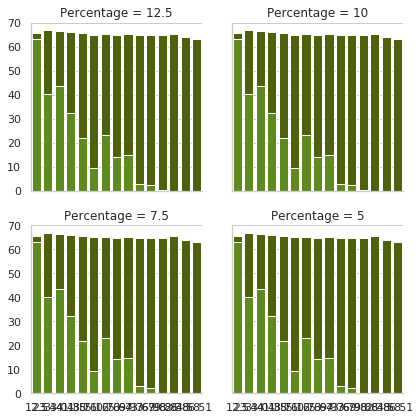

In [10]:
# LPRUNE
method12, filters_per_layer_12, full_accuracy_list_12 = makeDataFrameFromFile('logs/l2-hard-12.5.log', 12.5)
method10, filters_per_layer_10, full_accuracy_list_10 = makeDataFrameFromFile('logs/l2-hard-10.log', 10)
method7, filters_per_layer_7, full_accuracy_list_7 = makeDataFrameFromFile('logs/l2-hard-7.5.log', 7.5)
method5, filters_per_layer_5, full_accuracy_list_5 = makeDataFrameFromFile('logs/l2-hard-5.log', 5)

filters12 = getFiltersOfLayers(filters_per_layer_12, 0, -1)
filters10 = getFiltersOfLayers(filters_per_layer_10, 0, -1)
filters7 = getFiltersOfLayers(filters_per_layer_7, 0, -1)
filters5 = getFiltersOfLayers(filters_per_layer_5, 0, -1)

combinedMethod = pd.concat([method12, method10, method7, method5])

g = sns.FacetGrid(combinedMethod, col='Percentage', col_wrap=2, ylim=(0, 70))
g.map(sns.barplot, x='Percentage pruned' ,y='Before pruning', data=method12, color='#557000')
g.map(sns.barplot, x='Percentage pruned' ,y='After pruning', data=method12, color='#639c0e')


#print(combinedMethod)


# GEOMETRIC MEDIAN
method12, filters_per_layer_12, full_accuracy_list_12 = makeDataFrameFromFile('logs/median-hard-12.5.log', 12.5)
#method10, filters_per_layer_10, full_accuracy_list_10 = makeDataFrameFromFile('logs/median-hard-10.log', 10)
method7, filters_per_layer_7, full_accuracy_list_7 = makeDataFrameFromFile('logs/median-hard-7.5.log', 7.5)
#method5, filters_per_layer_5, full_accuracy_list_5 = makeDataFrameFromFile('logs/median-hard-5.log', 5)

filters12 = getFiltersOfLayers(filters_per_layer_12, 0, -1)
#filters10 = getFiltersOfLayers(filters_per_layer_10, 0, -1)
filters7 = getFiltersOfLayers(filters_per_layer_7, 0, -1)
#filters5 = getFiltersOfLayers(filters_per_layer_5, 0, -1)

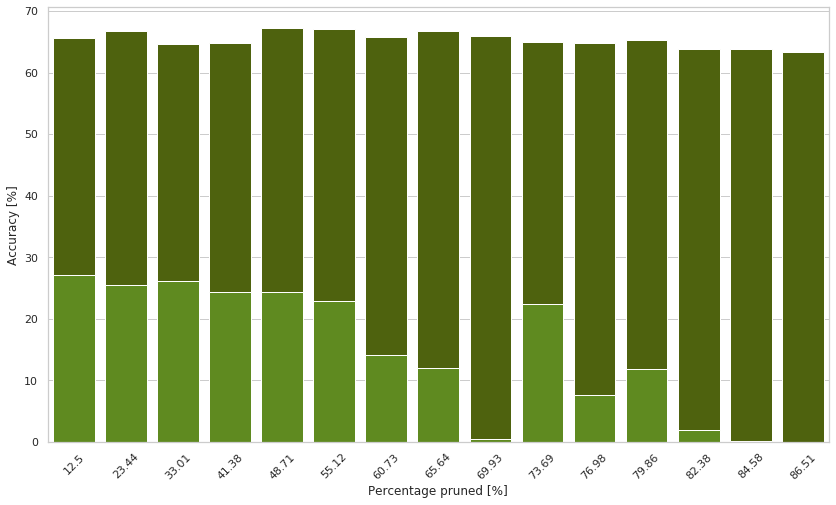

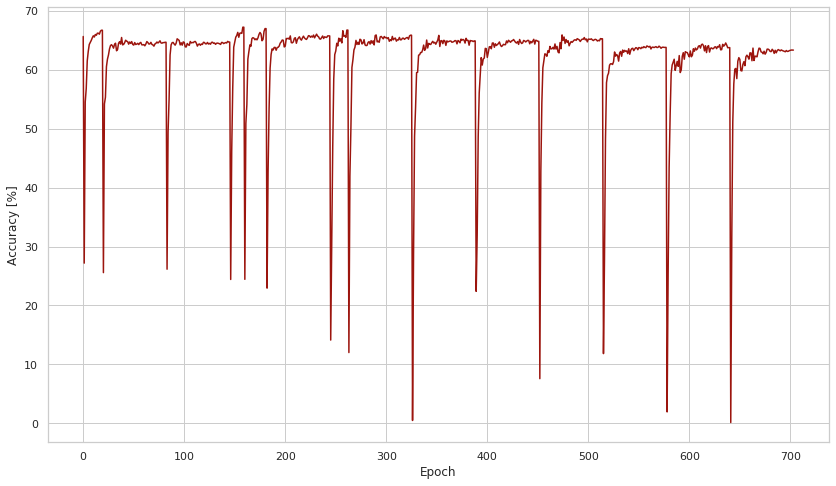

In [11]:
# 12.5 PERCENT
printAccuracy(method12)
printFullAccuracyGraph(full_accuracy_list_12)

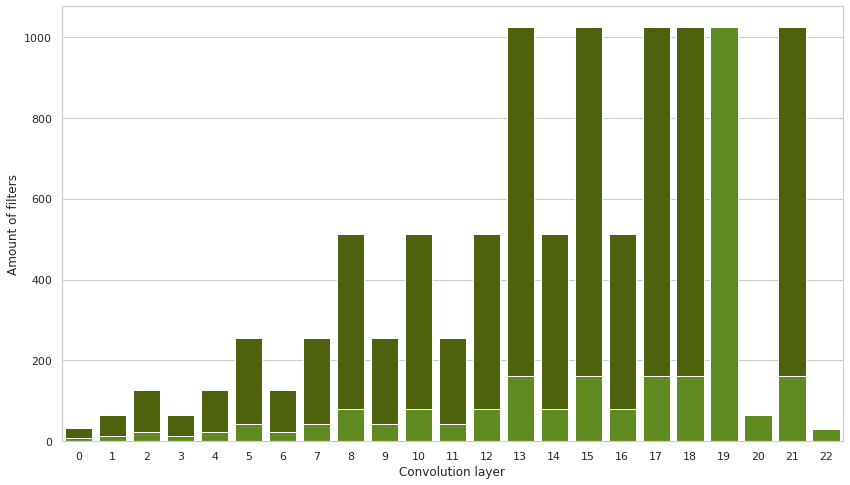

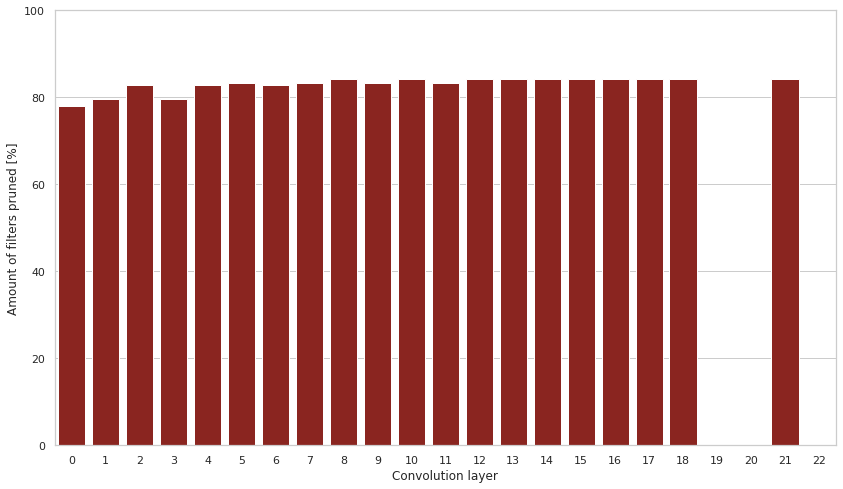

In [12]:
printFiltersPerLayer(filters12)
printFiltersPerLayerPercentage(filters12)

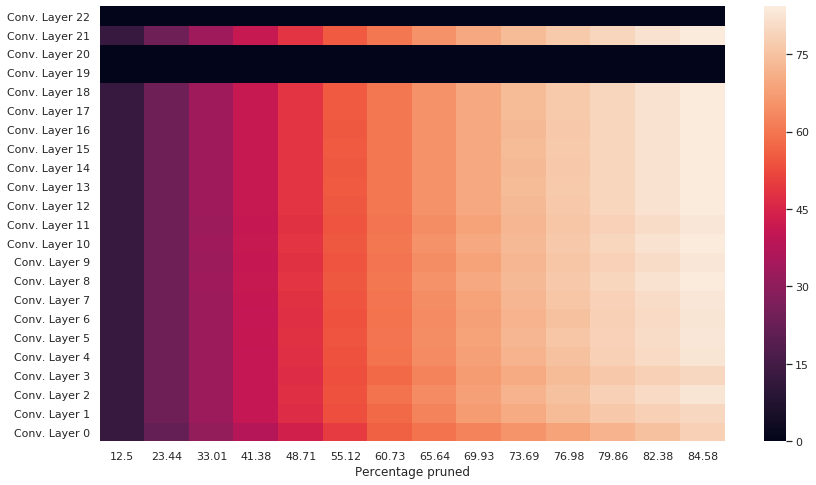

In [13]:
makeHeatMap(filters_per_layer_12, method12['Percentage pruned'])

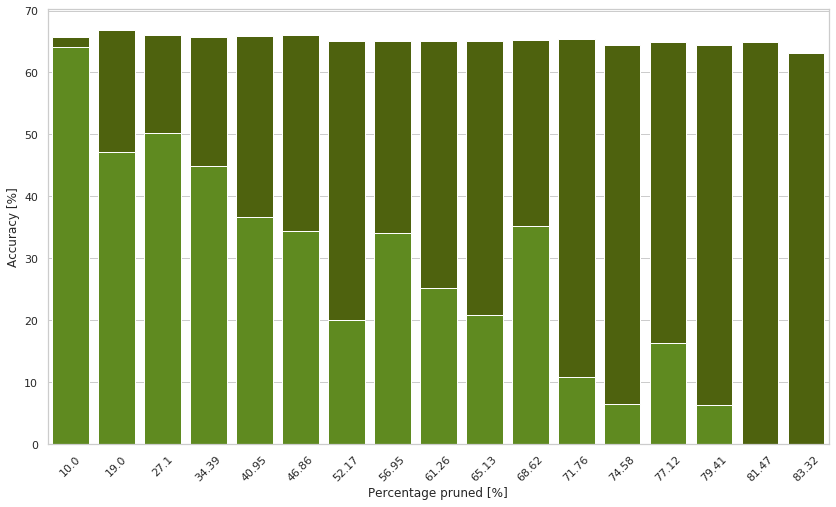

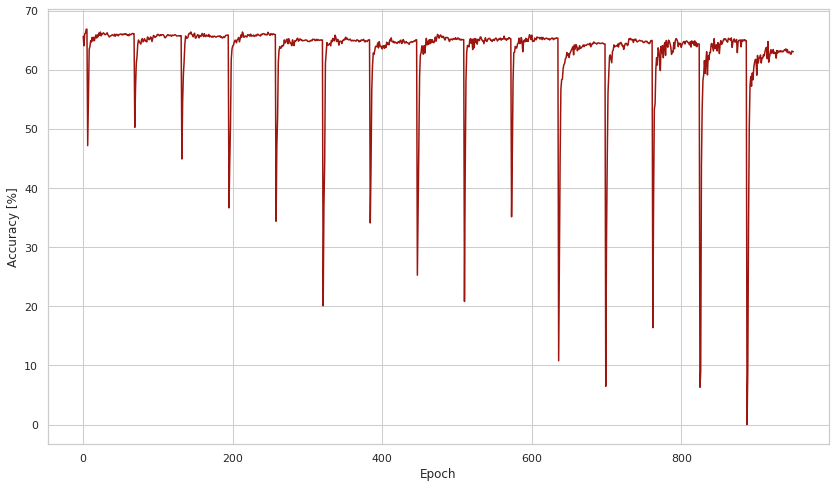

In [14]:
# 10 PERCENT
printAccuracy(method10)
printFullAccuracyGraph(full_accuracy_list_10)

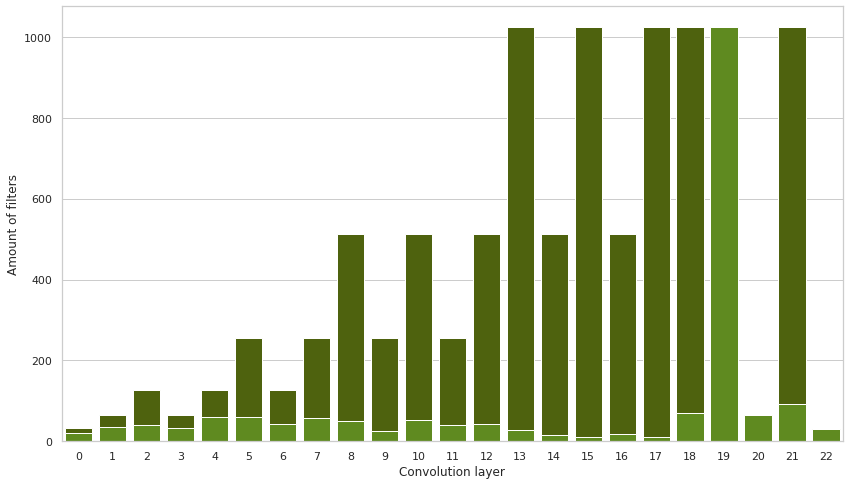

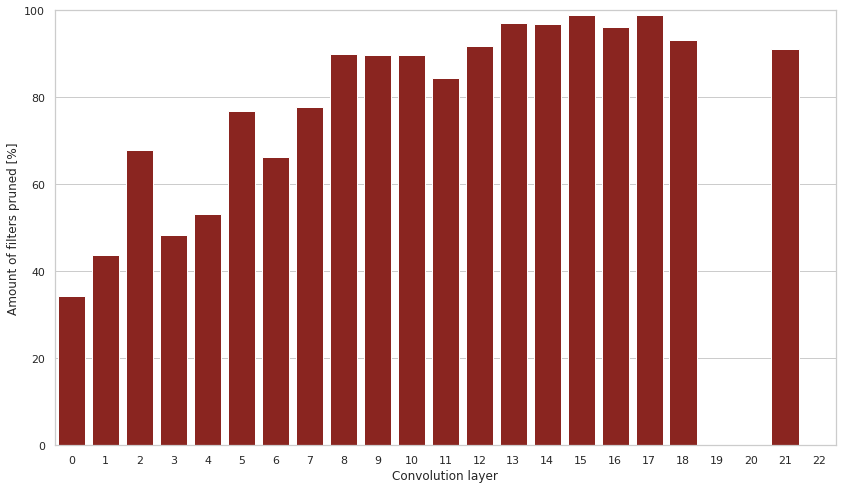

In [15]:
printFiltersPerLayer(filters10)
printFiltersPerLayerPercentage(filters10)

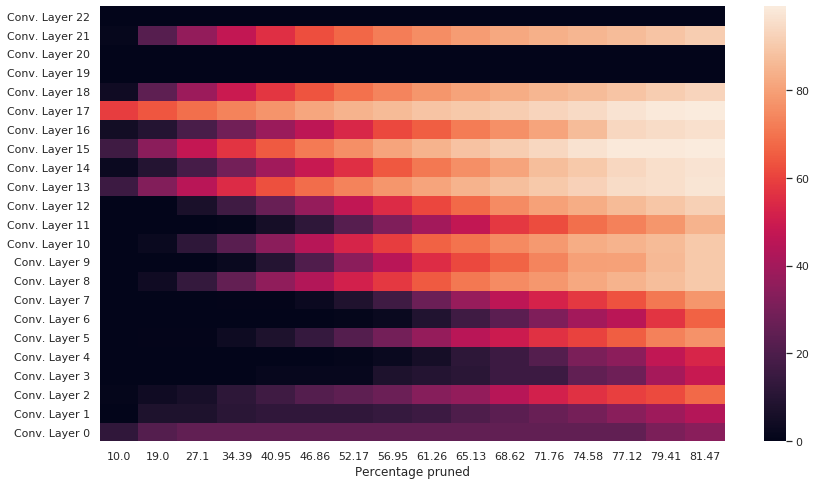

In [16]:
makeHeatMap(filters_per_layer_10, method10['Percentage pruned'])

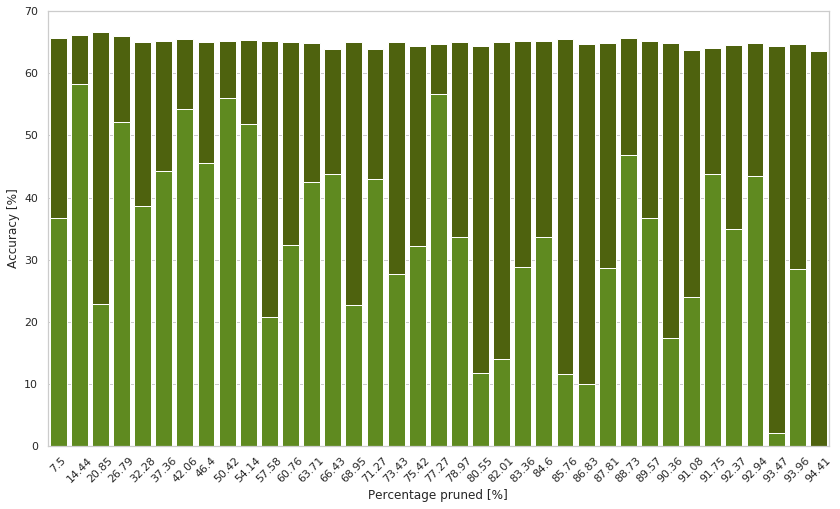

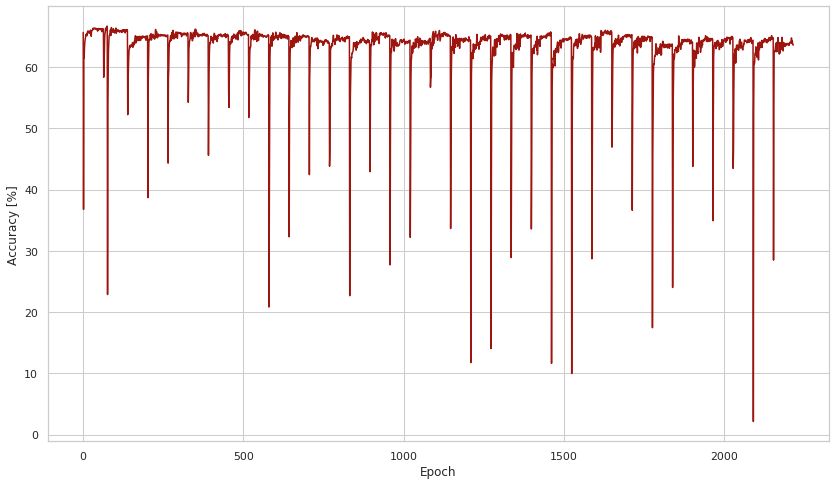

In [17]:
# 7.5 PERCENT
printAccuracy(method7)
printFullAccuracyGraph(full_accuracy_list_7)

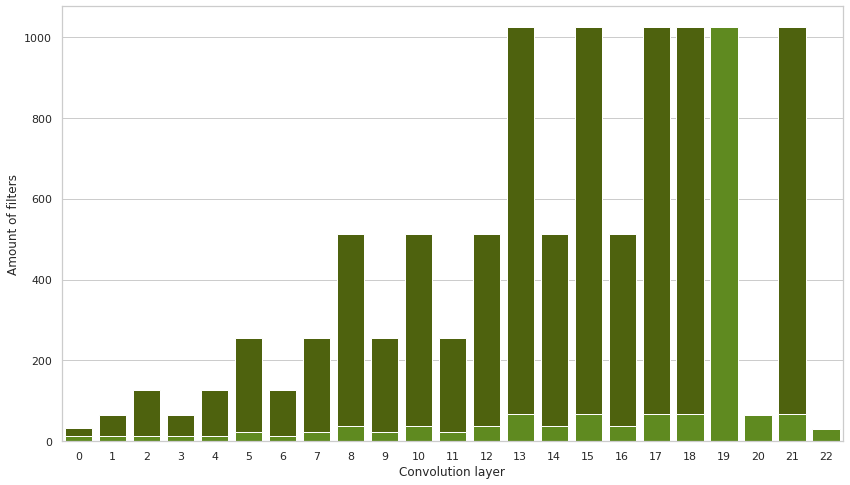

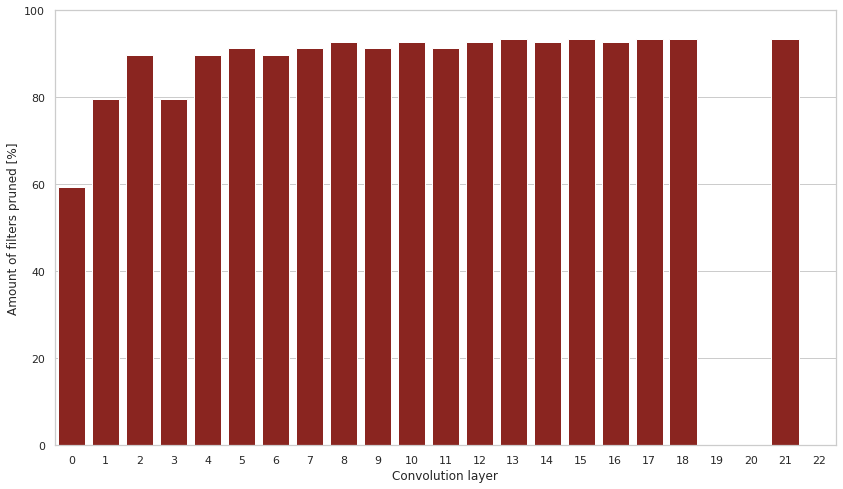

In [18]:
printFiltersPerLayer(filters7)
printFiltersPerLayerPercentage(filters7)

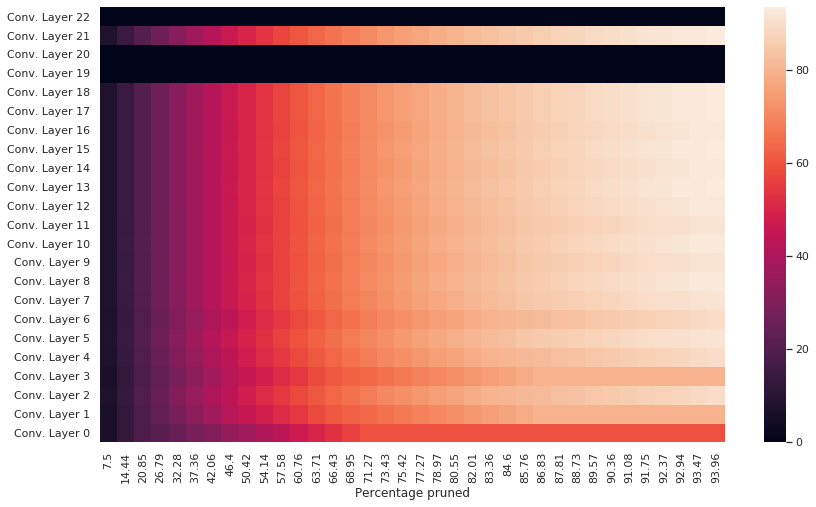

In [19]:
makeHeatMap(filters_per_layer_7, method7['Percentage pruned'])

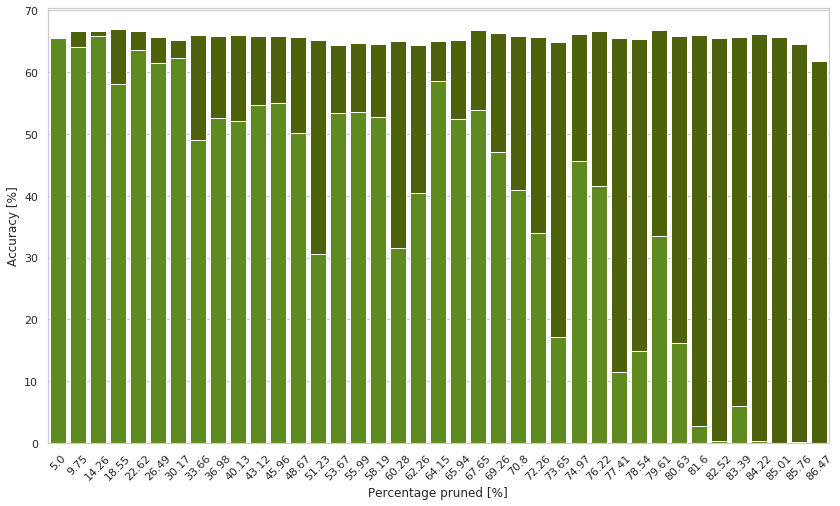

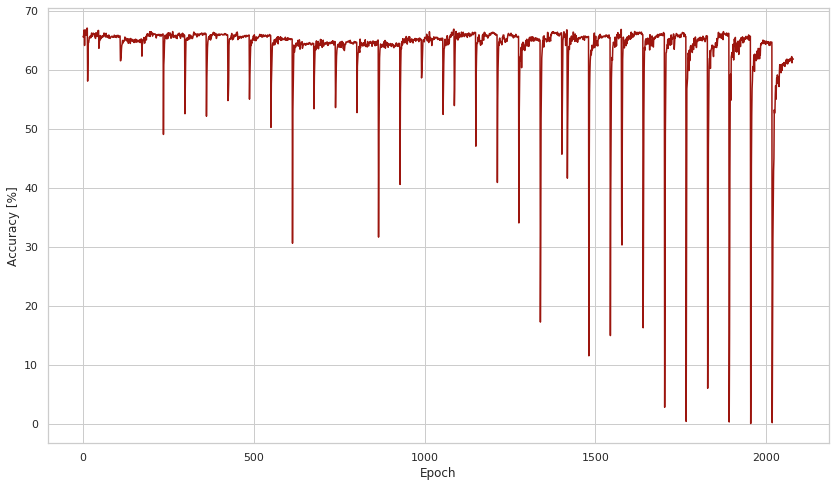

In [20]:
# 5 PERCENT
printAccuracy(method5)
printFullAccuracyGraph(full_accuracy_list_5)

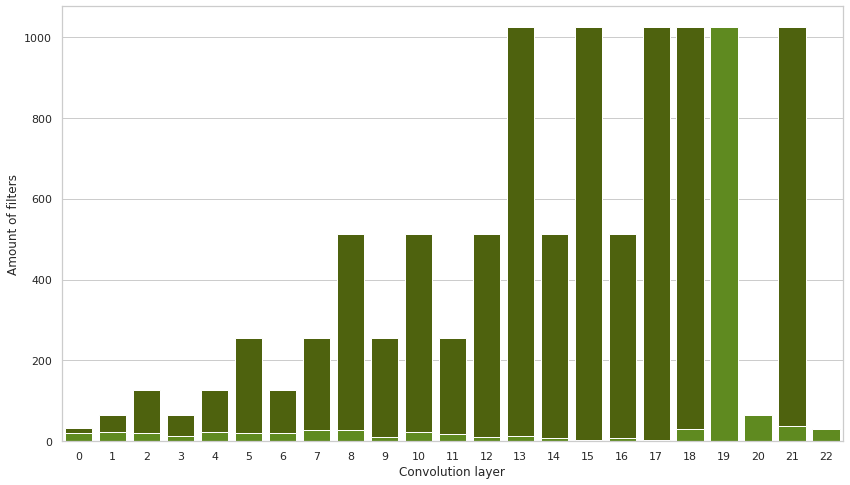

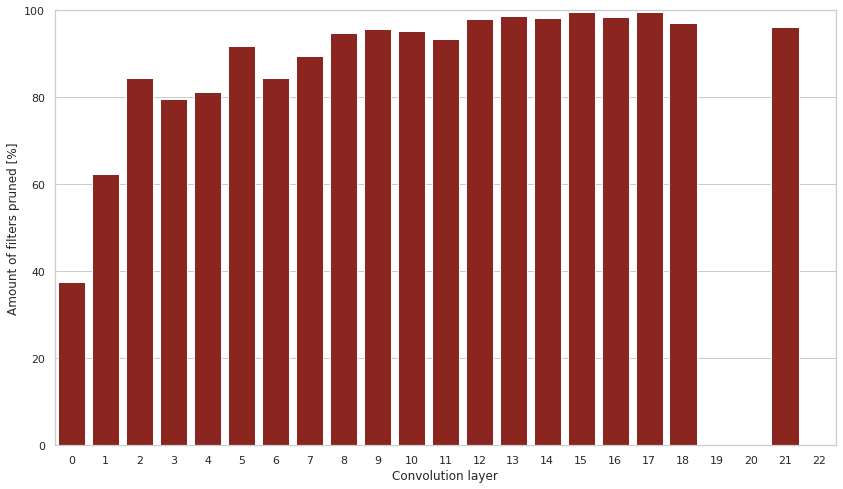

In [21]:
printFiltersPerLayer(filters5)
printFiltersPerLayerPercentage(filters5)

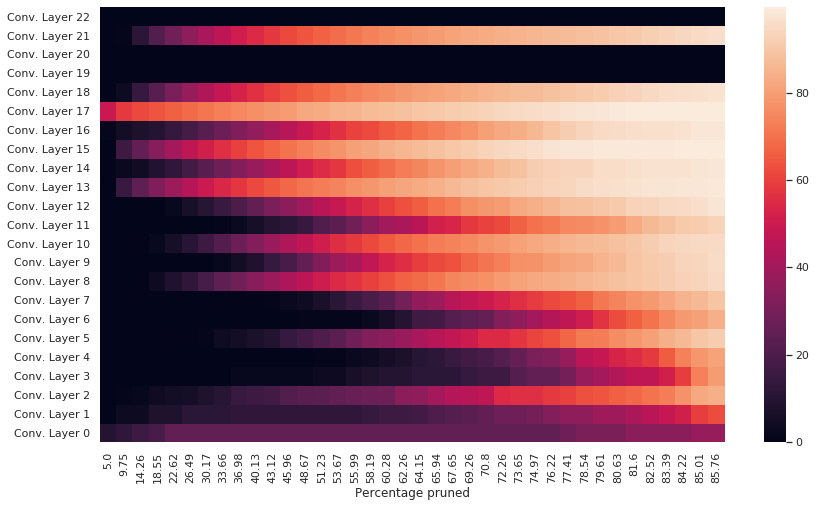

In [22]:
makeHeatMap(filters_per_layer_5, method5['Percentage pruned'])

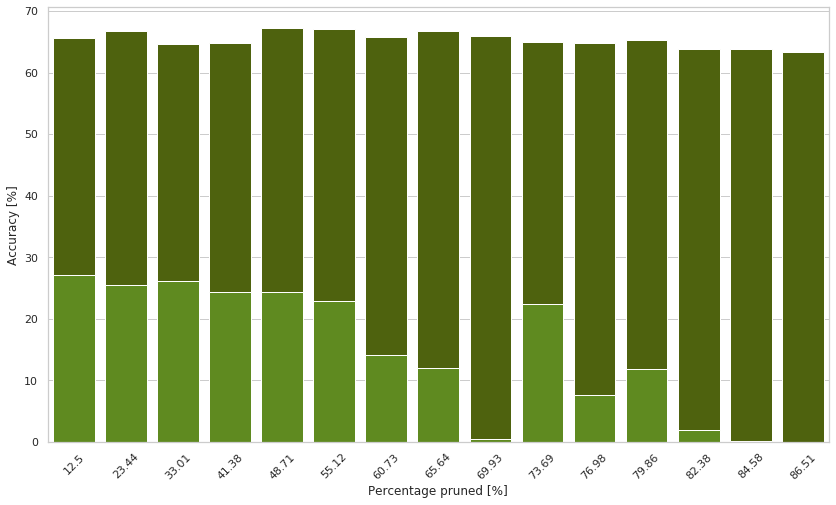

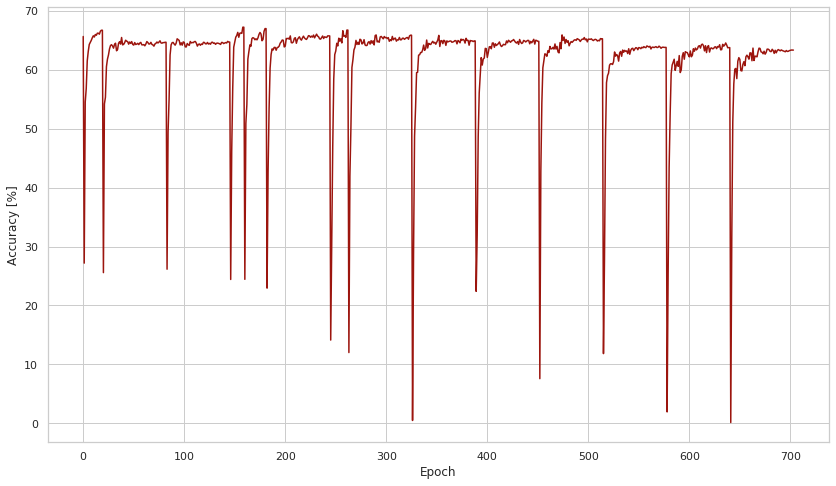

In [23]:
# GEOMETRIC MEDIAN
# 12.5 PERCENT
printAccuracy(method12)
printFullAccuracyGraph(full_accuracy_list_12)

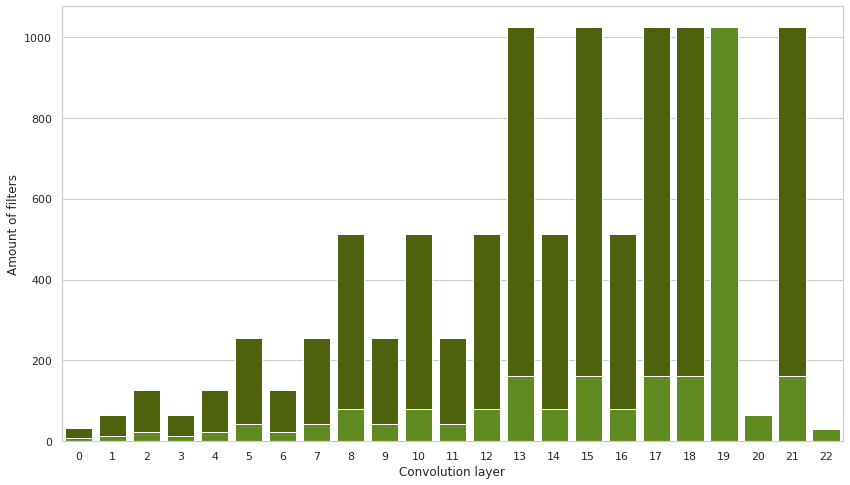

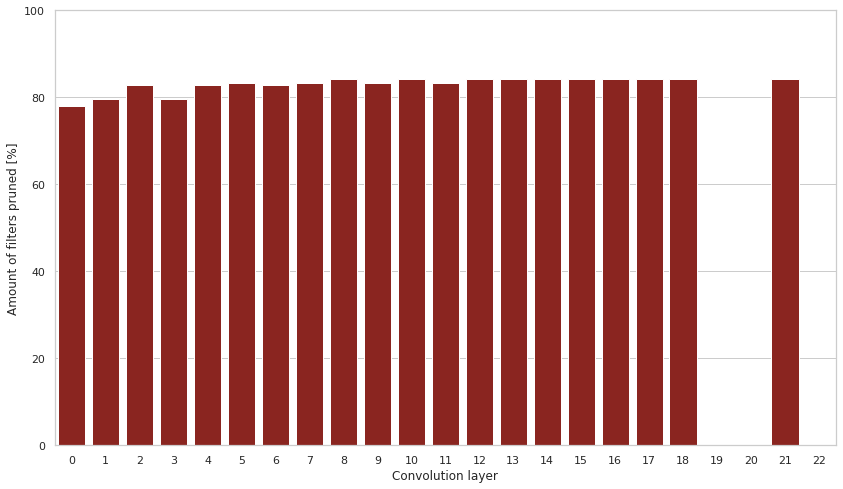

In [24]:
printFiltersPerLayer(filters12)
printFiltersPerLayerPercentage(filters12)

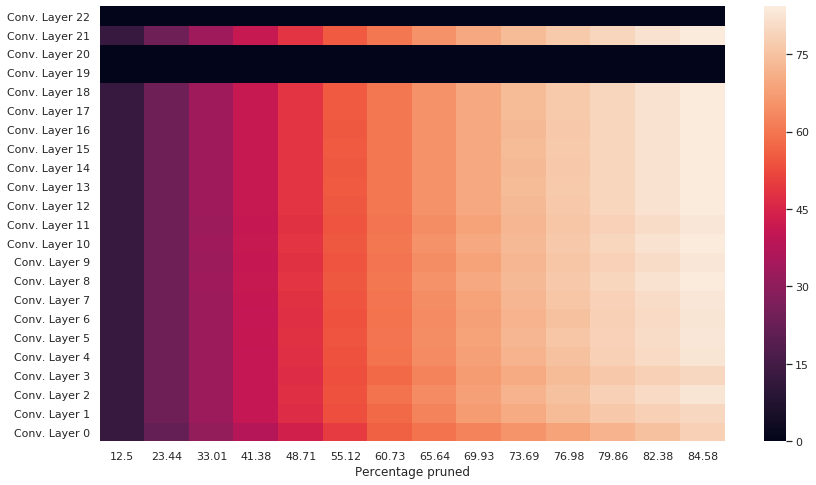

In [25]:
makeHeatMap(filters_per_layer_12, method12['Percentage pruned'])

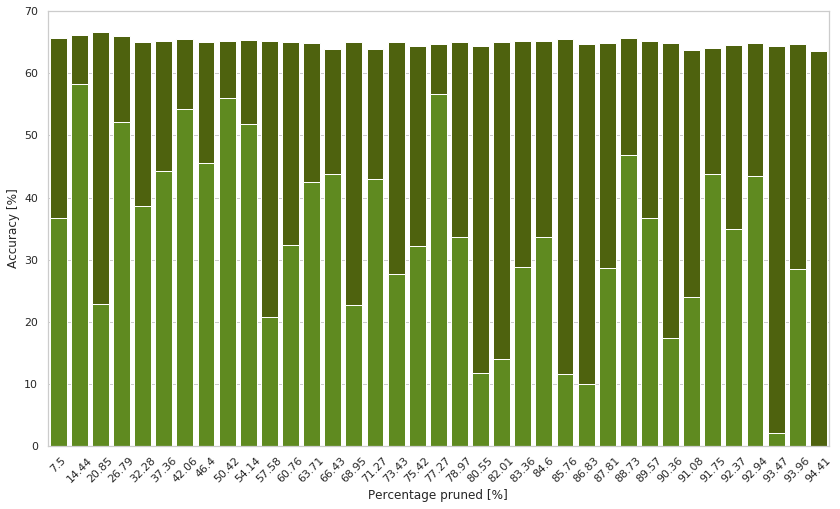

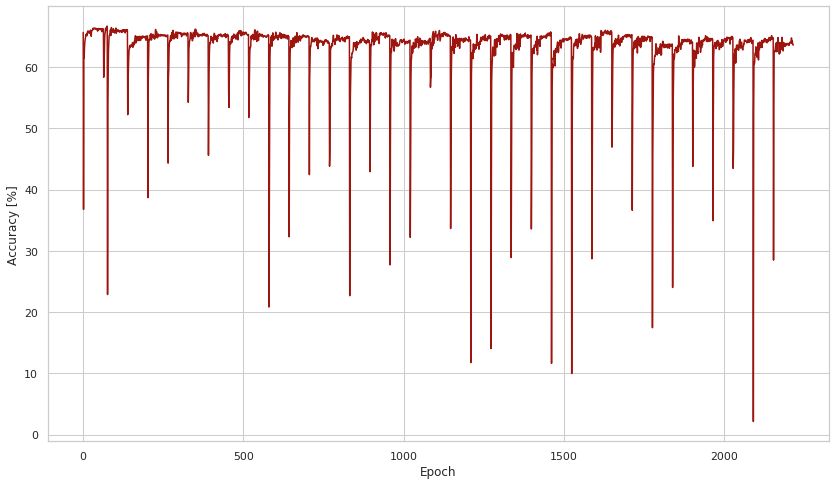

In [26]:
# 7.5 PERCENT
printAccuracy(method7)
printFullAccuracyGraph(full_accuracy_list_7)

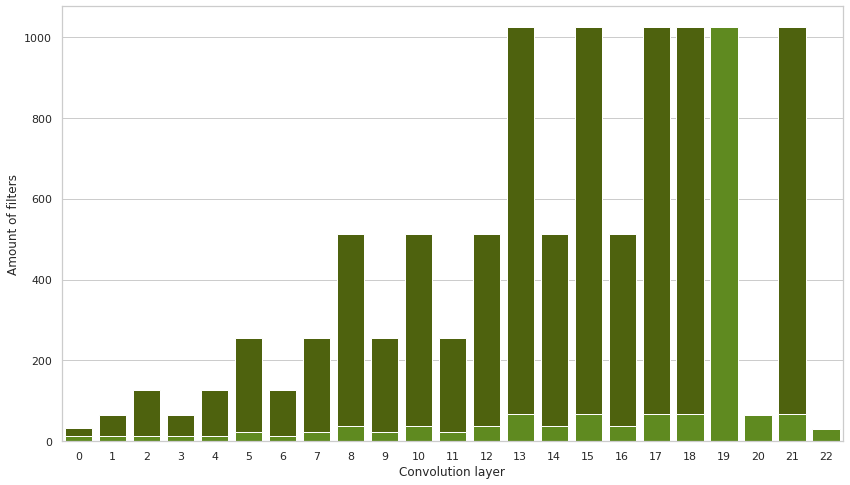

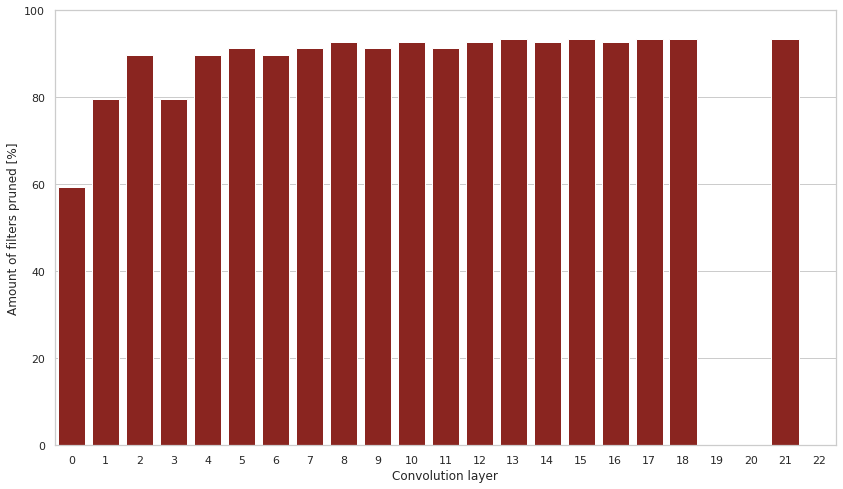

In [27]:
printFiltersPerLayer(filters7)
printFiltersPerLayerPercentage(filters7)

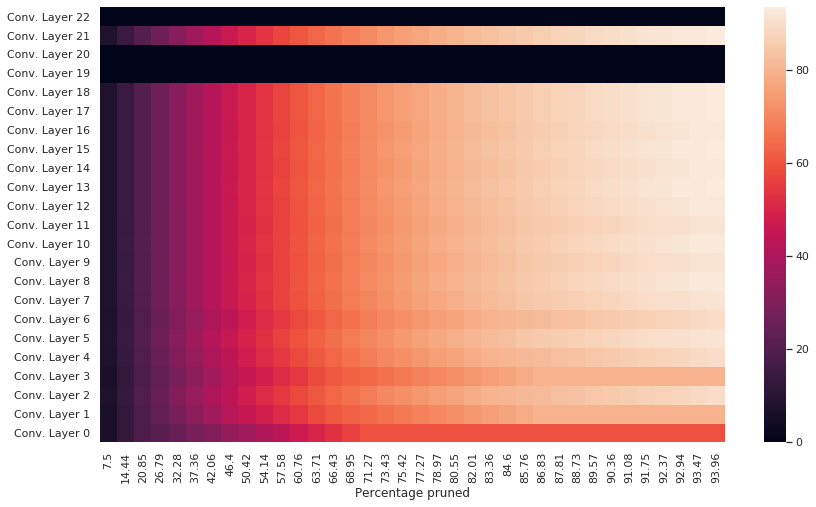

In [28]:
makeHeatMap(filters_per_layer_7, method7['Percentage pruned'])